In [8]:
from io import BytesIO
from itertools import islice
import math

import IPython.display
import ipywidgets as widgets
from imageio import imwrite
from ipywidgets import interact
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.io import wavfile
from scipy.signal import get_window

![Both Kinds!](img/both_kinds.png)

# Fast Fourier Transforms

[![Think DSP](http://greenteapress.com/wp/wp-content/uploads/2016/01/think_dsp_cover-229x300.jpg)](http://greenteapress.com/wp/think-dsp/)

In [2]:
def pulse_wave(period, width, N, samples=128):
    pw = width / period
    wave = np.zeros((N+1, samples))
    t = 2.0*np.pi * np.linspace(0.0, 2*np.pi, samples) / period
    for i in range(N-1):
        n = i+1
        wave[i,:] = 2.0/(n*np.pi) * np.sin(np.pi*n*pw) * np.cos(n*t)
    wave[N-1,:] = pw + wave[0:N-1,:].sum(axis=0)
    return wave

def plot_pulse_wave(period, pulse_width, harmonics):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    width = pulse_width * period
    t = np.linspace(0.0, 2*np.pi, 512)
    wave = pulse_wave(period, width, harmonics, 512)
    for i in range(harmonics-1):
        plt.plot(t, wave[i], color='blue')
    plt.plot(t, wave[harmonics-1], color='green', linewidth=2)

# [Pulse Waves](https://en.wikipedia.org/wiki/Pulse_wave)

$$\Large{\textrm{At time t for period T and duty-cycle $\tau$:}
\\f(t) = \frac{\tau}{T} + \sum_{n=1}^{\infty}\frac{2}{n\pi}sin\left(\frac{\pi n\tau}{T}\right)
cos\left(\frac{2\pi n t}{T} \right)}$$


In [3]:
interact(plot_pulse_wave,
    period = widgets.FloatSlider(min=0.5, max=6.0, value=3.0, step=0.5, description='period'),
    pulse_width = widgets.FloatSlider(min=0.1, max=0.99, value=0.5, step=0.1, description='duty-cycle'),
    harmonics = widgets.IntSlider(min=1, max=50, value=8, step=1, description='harmonics'))

interactive(children=(FloatSlider(value=3.0, description='period', max=6.0, min=0.5, step=0.5), FloatSlider(va…

<function __main__.plot_pulse_wave(period, pulse_width, harmonics)>

# [The Gauss Map](https://en.wikipedia.org/wiki/Gauss_iterated_map)
$$\Huge{x_{n+1} = e^{(-\alpha x_{n}^2)}+\beta}$$

In [4]:
def gauss_map(x,alpha,beta):
    while True:
        yield x
        x = math.exp(-alpha*x*x) + beta
        
def gauss_hist(alpha,beta,n,count,skip):
    gm = gauss_map(0.01,alpha,beta)
    hist = np.histogram(list(islice(gm,skip,skip+count)),n,(-1.5,1.5))[0]
    scale = 1.0 / np.max(hist)
    return hist * scale

def plot_gauss_hist(alpha,beta):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    plt.plot(gauss_hist(alpha, beta, 720, 512, 4096), color='green')
    plt.show()

In [5]:
interact(plot_gauss_hist, alpha=widgets.FloatSlider(min=1.0,max=9.75, value=4.0, step=0.5, description=r'\(\Large{\alpha}\)'),
    beta=widgets.FloatSlider(min=-1.0,max=1.0, value=-0.5, step=0.05, description=r'\(\Large{\beta}\)'))

interactive(children=(FloatSlider(value=4.0, description='\\(\\Large{\\alpha}\\)', max=9.75, min=1.0, step=0.5…

<function __main__.plot_gauss_hist(alpha, beta)>

In [40]:
def gauss_image(alpha, beta_min, beta_max, width, height):
    img = np.zeros(shape=(height, width,3))
    for y, beta in enumerate(np.linspace(beta_min, beta_max, width)):
        img[:,y,1] = gauss_hist(alpha, beta, height, 512, 4096)[::-1]
    img = 255 * img / img.max()
    return img.astype(np.uint8)

def plot_gauss_image(alpha):
    im_bytes = BytesIO()
    imwrite(im_bytes, gauss_image(alpha, -1.0, 1.0, 600, 480), format='png')
    return IPython.display.display(IPython.display.Image(data=im_bytes.getvalue()))

def segment(hist, n, win):
    return np.multiply(np.real(np.fft.irfft(hist, n=n)), win)

In [7]:
interact(plot_gauss_image, alpha=widgets.FloatSlider(min=1.0,max=9.75, value=5.0, step=0.5, description=r'\(\Large{\alpha}\)'))

interactive(children=(FloatSlider(value=5.0, description='\\(\\Large{\\alpha}\\)', max=9.75, min=1.0, step=0.5…

<function __main__.plot_gauss_image(alpha)>

Text(0, 0.5, 'windowed signal')

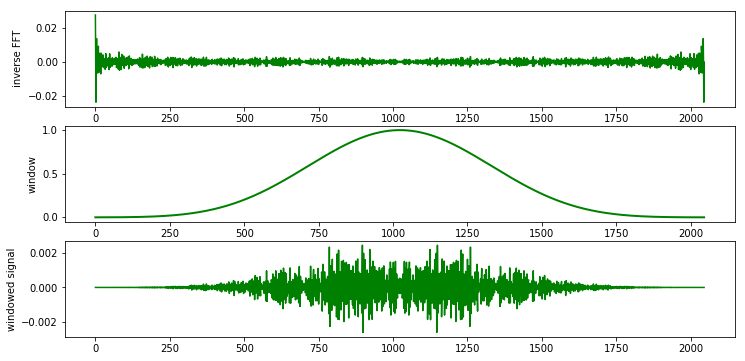

In [42]:
# Example of a windowed IFFT.
%matplotlib inline
N = 1024
window = get_window('blackmanharris',2*(N-1))
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(12, 6)
axs[0].plot(np.real(np.fft.irfft(gauss_hist(9.0, -0.6, 1024, 512, 409), n=2046)), color='green')
axs[0].set_ylabel('inverse FFT')
axs[1].plot(window, color='green', linewidth=2)
axs[1].set_ylabel('window')
axs[2].plot(segment(gauss_hist(9.0,-0.6,1024,512,409),2046,window), color='green')
axs[2].set_ylabel('windowed signal')

![the first thing to do would be to consider time as offically ended](img/time_officially_ended.png)

In [39]:
def scan(alpha_min,alpha_max,alpha_count,beta_min,beta_max,beta_count):
    d_alpha = (alpha_max - alpha_min) / alpha_count
    d_beta = (beta_max - beta_min) / beta_count
    beta = beta_min
    for i in range(alpha_count):
        alpha = alpha_min + d_alpha * i
        if i % 2 == 1:
            db = -d_beta
        else:
            db = d_beta
        for j in range(beta_count):
            yield(alpha, beta)
            beta += db

            
def frame_count(dur,N,H,bias,rate=44100):
    frames = dur * rate
    segments = int(frames / H)
    alpha_count = int(bias * np.sqrt(segments))
    beta_count = int(segments / alpha_count)
    segments = alpha_count * beta_count
    frames = 2 * (N-1) + segments * H
    return frames, alpha_count, beta_count


def build_frames(dur,N,n,H,bias,rate=44100):
    pan_range = np.arange(N)
    frames, alpha_count, beta_count = frame_count(dur,n,H,bias,rate)
    pan = np.zeros(alpha_count * beta_count)
    output = np.zeros(frames,dtype=np.float32)
    window = get_window('blackmanharris',n)
    hist_count = 4 * N
    for i, pars in enumerate(scan(1.0,9.75,alpha_count,-0.95,0.5,beta_count)):
        alpha, beta = pars
        hist = gauss_hist(alpha,beta,N,hist_count,N)
        pan[i] = np.average(pan_range, weights=hist) / N
        seg = segment(hist,n,window)
        start = i * H
        end = start + n
        output[start:end] += seg
    return output, pan


In [41]:
def dump_mono(data,fname,rate=44100):
    scale = 32767.0 / np.max(data) 
    buff = scale * data
    wavfile.write(fname, rate, buff.astype(np.int16))
    
def dump_stereo(data, pan, H, depth, fname, reverse=True, rate=44100):
    scale = 32767.0 / np.max(data)
    floor = 1.0 - depth
    f = UnivariateSpline(np.arange(0,len(data),H)[0:len(pan)], pan)
    pan_interp = depth * f(np.arange(len(data)))
    output = np.zeros((len(data),2))
    output[:,0] = scale * (floor + pan_interp) * data
    if reverse:
        output[::-1,1] = scale * (1.0 - pan_interp) * data
    else:
        output[:,1] = scale * (1.0 - pan_interp) * data   
    wavfile.write(fname, rate, output.astype(np.int16)) 

In [ ]:
def write_frames(path, prefix, alpha_min, alpha_max, beta_min, beta_max, frames, width=1280, height=720):
    if not os.path.exists(path):
        os.makedirs(path)
    d_alpha = (alpha_max - alpha_min) / frames
    for i in range(frames):
        alpha = alpha_min + i * d_alpha
        fname = path + '/' + prefix + ('000000'+str(i))[-6:] + '.png'
        img = gauss_image(alpha, beta_min, beta_max, width, height)

